## Discretisation plus Encoding

What shall we do with the variable after discretisation? should we use the buckets as a numerical variable? or should we use the intervals as categorical variable?

The answer is, you can do either.

If you are building decision tree based algorithms and the output of the discretisation are integers (each integer referring to a bin), then you can use those directly, as decision trees will pick up non-linear relationships between the discretised variable and the target.

If you are building linear models instead, the bins may not necessarily hold a linear relationship with the target. In this case, it may help improve model performance to treat the bins as categories and to one hot encoding, or target guided encodings like mean encoding, weight of evidence, or target guided ordinal encoding.

We can easily do so by combining feature-engine's discretisers and encoders.

## In this demo

We will perform equal frequency discretisation followed by target guided orginal encoding using the titanic dataset

If instead you would like to do weight of evidence or mean target encoding, you need only replace the Feature-engine's encoder.

In [38]:
# import libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.encoding import OrdinalEncoder

In [39]:
# load data

cols = ['age','fare','survived']
data = pd.read_csv('titanic.csv', usecols=cols)
data.head()


,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  1309 non-null   int64  
 1   age       1046 non-null   float64
 2   fare      1308 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 30.8 KB


- We can see there are also some null values in both age and fare variables
- This also needs to be taken care

In [40]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

- Imputing the missing data in age and fare by using random sample imputation

In [5]:
df = X_train['age'].copy()
df

501     13.0000
588      4.0000
402     30.0000
1193        NaN
686     22.0000
         ...   
763      0.1667
835         NaN
1216        NaN
559     20.0000
684     32.0000
Name: age, Length: 916, dtype: float64

In [7]:
random_sample = df.dropna().sample(df.isnull().sum())
random_sample

1276    31.0
551     50.0
572     28.0
316     51.0
323     30.0
        ... 
464     32.0
42      59.0
23      42.0
1224    21.0
823     31.0
Name: age, Length: 175, dtype: float64

In [9]:
# get the index of the random sample with the ones from the missing ones
random_sample.index = df[df.isnull()].index
random_sample.index

Int64Index([1193,  971, 1284, 1027, 1023, 1255, 1114, 1034,  384, 1137,
            ...
            1077, 1262,  802,  882,  976,  705,  277, 1033,  835, 1216],
           dtype='int64', length=175)

In [10]:
# now set the random sample values to the missing variables in df
df.loc[df.isnull()] = random_sample
df.isnull().sum()

0

In [41]:
## lets write a function to perform these

def impute_na(data, variable):

    df= data.copy()
    df[variable + '_random'] = df[variable]
    
    # generate random samples
    samples = df[variable].dropna().sample(df[variable].isnull().sum(), random_state=0)
    
    # get the index of the missing observations
    samples.index = df[df[variable].isnull()].index
    
    # set the missing values with the samples
    df.loc[df[variable].isnull(), variable + '_random'] = samples
    
    return df[variable + '_random']

In [42]:
# replace na in both the train and test sets
X_train['age'] = impute_na(X_train, 'age')
X_test['age'] = impute_na(X_test, 'age')

X_train['fare'] = impute_na(X_train, 'fare')
X_test['fare'] = impute_na(X_test, 'fare')

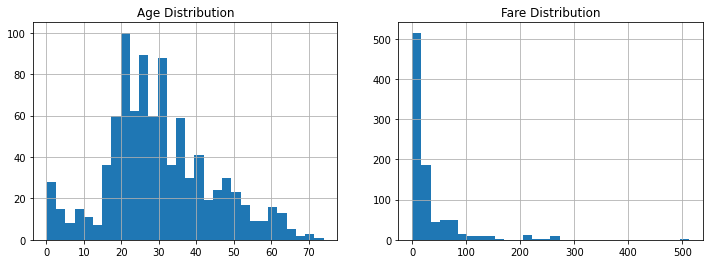

In [43]:
# lets xplore the distribution of age and fare in the original data

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
X_train['age'].hist(bins = 30)
plt.title('Age Distribution')

plt.subplot(1,2,2)
X_train['fare'].hist(bins = 30)
plt.title('Fare Distribution')
plt.show()

## Equal frequency discretisation with Feature-Engine

In [44]:
# with feature engine we can automate the process for many variables
# in one line of code
# to encode variables we need them returned as objects for feature-engine

disc = EqualFrequencyDiscretiser(q=10, variables = ['age', 'fare'], return_object=True)

disc.fit(X_train)

EqualFrequencyDiscretiser(return_object=True, variables=['age', 'fare'])

In [45]:
# in the binner dict, we can see the limits of the intervals. Note
# that the intervals have different widths

disc.binner_dict_

{'age': [-inf, 16.0, 20.0, 22.0, 25.0, 28.0, 31.0, 36.0, 42.0, 50.0, inf],
 'fare': [-inf,
  7.55,
  7.7958,
  8.05,
  10.5,
  14.4542,
  21.075,
  26.55,
  40.125,
  79.025,
  inf]}

In [46]:
# transform train and test data

train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

In [47]:
train_t.head()

,age,fare
501,0,5
588,0,6
402,5,4
1193,7,1
686,2,1


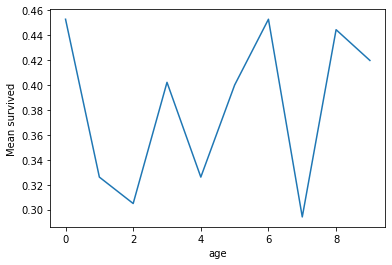

In [56]:
# now lets explore if the bins have linear relationship with the target
# for age
pd.concat([train_t, y_train], axis = 1).groupby('age')['survived'].mean().plot()
plt.ylabel('Mean survived')
plt.show()

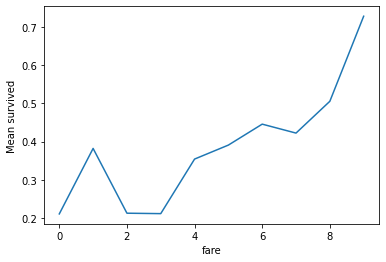

In [57]:
# now lets explore if the bins have linear relationship with the target
# for fare
pd.concat([train_t, y_train], axis = 1).groupby('fare')['survived'].mean().plot()
plt.ylabel('Mean survived')
plt.show()

None of the variables show a monotonic relationship between the intervals of the discrete variable and the mean of survival. We can encode the intervals to return a monotonic relationship:

# Ordinal encoding with Feature-Engine

In [58]:
enc = OrdinalEncoder(encoding_method='ordered')

enc.fit(train_t,y_train)

OrdinalEncoder(variables=['age', 'fare'])

In [59]:
# transform train and test data
train_t = enc.transform(train_t)
test_t = enc.transform(test_t)

In [60]:
enc.encoder_dict_

{'age': {7: 0, 2: 1, 1: 2, 4: 3, 5: 4, 3: 5, 9: 6, 8: 7, 0: 8, 6: 9},
 'fare': {0: 0, 3: 1, 2: 2, 4: 3, 1: 4, 5: 5, 7: 6, 6: 7, 8: 8, 9: 9}}

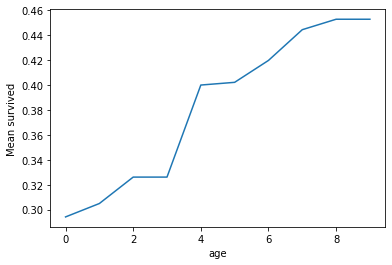

In [61]:
# now lets explore if the bins have linear relationship with the target
# for age
pd.concat([train_t, y_train], axis = 1).groupby('age')['survived'].mean().plot()
plt.ylabel('Mean survived')
plt.show()

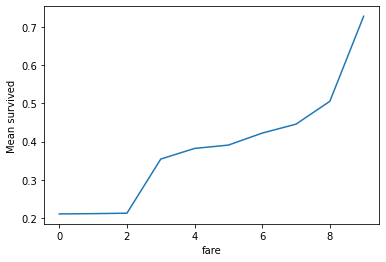

In [62]:
# now lets explore if the bins have linear relationship with the target
# for age
pd.concat([train_t, y_train], axis = 1).groupby('fare')['survived'].mean().plot()
plt.ylabel('Mean survived')
plt.show()

    Now we obtained a monotonic relationship between variables and the target.